# Mini-Project 1: Image classification and Regression

*Author: Alexandre Zouaoui (alexandre.zouaoui@telecom-paristech.fr)*

## Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.patches as patches
import seaborn as sns

from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.losses import categorical_crossentropy
from keras.initializers import zeros

from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten

Using TensorFlow backend.


## Style

In [2]:
sns.set_style("darkgrid")

## Global variables

In [3]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72
# Number of classes
N_CLASSES = 3

## Utility functions

In [4]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

In [5]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

def visualize_prediction(x, y, title=None):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title(title)

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

## Display shapes

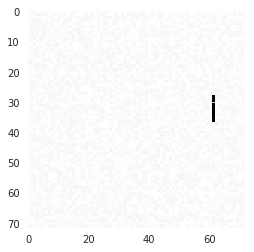

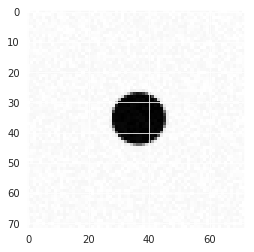

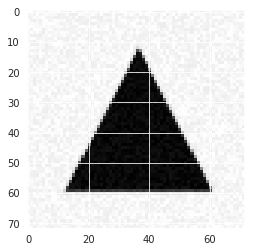

In [6]:
plt.figure()
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.figure()
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

plt.figure()
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray');

## 3 - Simple classification

In [8]:
# Generate dataset
X_train, Y_train = generate_dataset_classification(300, 20)
# Convert y_train to categorical 
y_train = np_utils.to_categorical(Y_train, num_classes=N_CLASSES)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [22]:
# Build model
model = Sequential()
model.add(Dense(N_CLASSES, input_shape=(IMAGE_SIZE*IMAGE_SIZE,),
                activation="softmax",
                kernel_initializer="uniform"))
print(model.summary())
# Compile and train the model
model.compile(optimizer=SGD(lr=3e-4, nesterov=True),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(x=X_train, y=y_train, 
                    batch_size=32, 
                    epochs=800, 
                    verbose=0, 
                    shuffle=True, 
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________
None


**Comment:**

* We use 20% of the training data as the validation set.

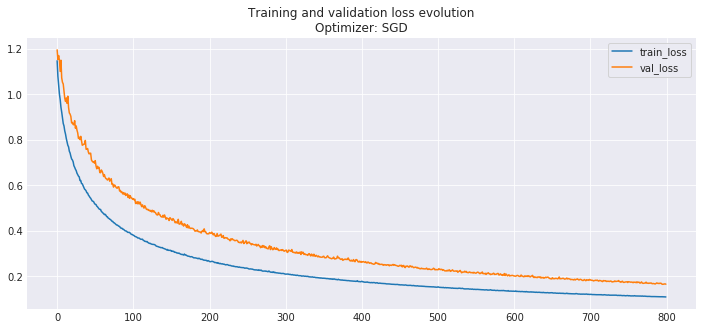

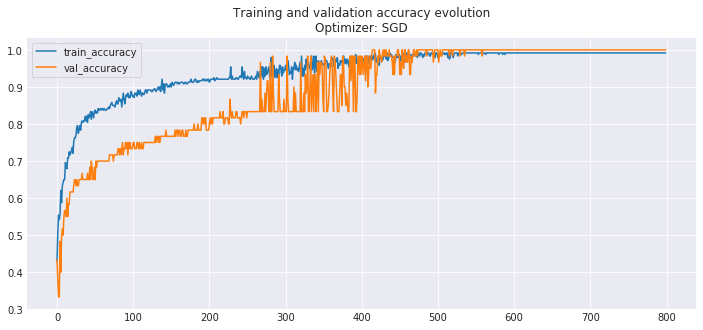

In [23]:
plt.figure(figsize=(12, 5))
plt.title("Training and validation loss evolution\n"
         "Optimizer: SGD")
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend(frameon=True);

plt.figure(figsize=(12, 5))
plt.title("Training and validation accuracy evolution\n"
         "Optimizer: SGD")
plt.plot(history.history["acc"], label="train_accuracy")
plt.plot(history.history["val_acc"], label="val_accuracy")
plt.legend(frameon=True);

In [24]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [25]:
# Build model
model = Sequential()
model.add(Dense(N_CLASSES, input_shape=(IMAGE_SIZE*IMAGE_SIZE,),
                activation="softmax",
                kernel_initializer="uniform"))
print(model.summary())
# Compile and train the model
model.compile(optimizer=Adam(lr=3e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(x=X_train, y=y_train, 
                    batch_size=32, 
                    epochs=100, 
                    verbose=0, 
                    shuffle=True, 
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________
None


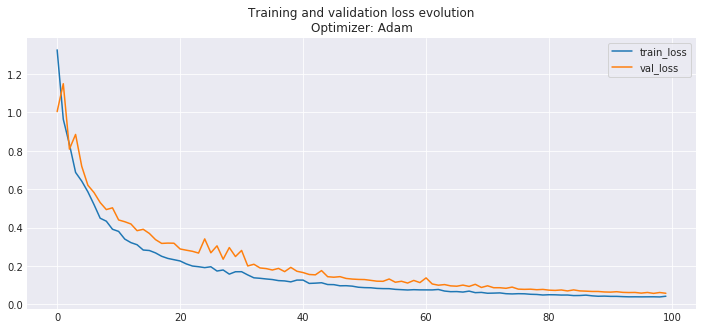

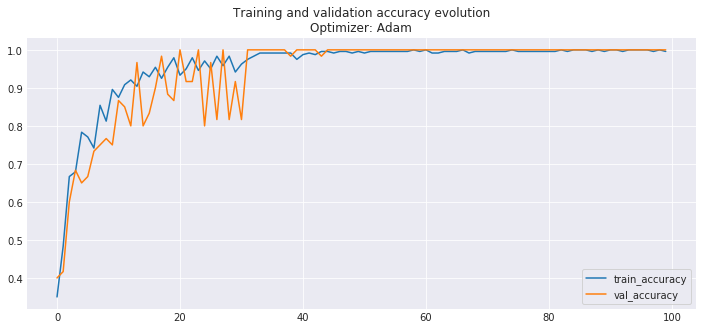

In [21]:
plt.figure(figsize=(12, 5))
plt.title("Training and validation loss evolution\n"
         "Optimizer: Adam")
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend(frameon=True);

plt.figure(figsize=(12, 5))
plt.title("Training and validation accuracy evolution\n"
         "Optimizer: Adam")
plt.plot(history.history["acc"], label="train_accuracy")
plt.plot(history.history["val_acc"], label="val_accuracy")
plt.legend(frameon=True);

In [26]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

**Comment:**

* The training is much faster when using ``Adam`` optimizer (40 epochs to reach 1.0 validation accuracy) as opposed to ``SGD`` with the same learning rate ``3e-4`` (500 epochs to reach 1.0 validation accuracy).

## 4 - Visualization of the Solution

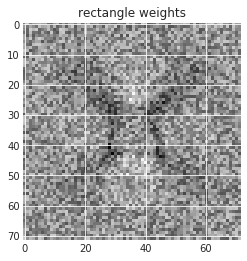

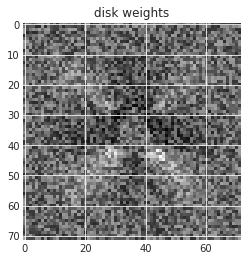

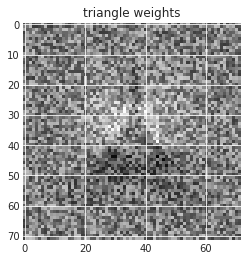

In [35]:
CLASSES = {0: "rectangle",
           1: "disk", 
           2: "triangle"}

weights = model.get_weights() # Weights and biases

for j in range(weights[0].shape[1]):
    plt.figure()
    plt.title(f"{CLASSES[j]} weights")
    plt.imshow(weights[0][:, j].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="gray")

**Comment:**

* Note that we omit the biases.

## 5 - A more difficult Classification Problem

In [44]:
# Generate dataset
X_train, Y_train = generate_dataset_classification(300, 20, True)
# Convert y_train to categorical 
y_train = to_categorical(Y_train, num_classes=N_CLASSES)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [45]:
# Build model
model = Sequential()
model.add(Dense(N_CLASSES, input_shape=(IMAGE_SIZE*IMAGE_SIZE,),
                activation="softmax",
                kernel_initializer="uniform"))
print(model.summary())
# Compile and train the model
model.compile(optimizer=Adam(lr=3e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
history = model.fit(x=X_train, y=y_train, 
                    batch_size=32, 
                    epochs=200, 
                    verbose=0, 
                    shuffle=True, 
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________
None


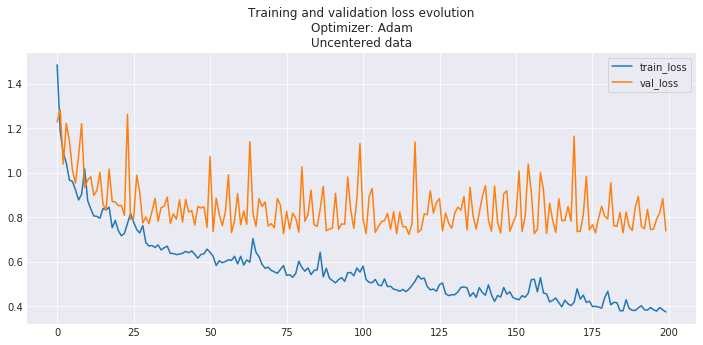

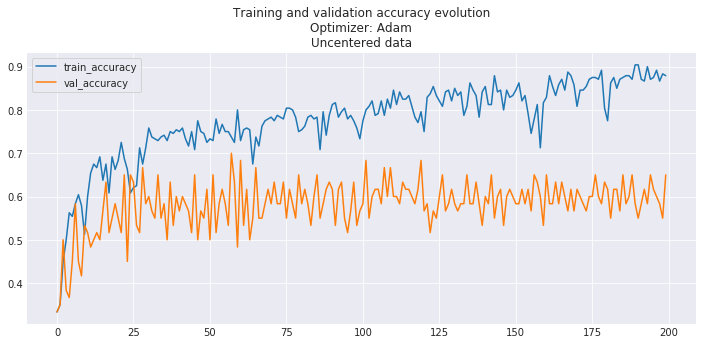

In [46]:
plt.figure(figsize=(12, 5))
plt.title("Linear classifier - Uncentered data\n"
        "Training and validation loss evolution\n"
         "Optimizer: Adam")
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend(frameon=True);

plt.figure(figsize=(12, 5))
plt.title("Linear classifier - Uncentered data\n"
        "Training and validation accuracy evolution\n"
         "Optimizer: Adam")
plt.plot(history.history["acc"], label="train_accuracy")
plt.plot(history.history["val_acc"], label="val_accuracy")
plt.legend(frameon=True);

**Comment:**

* We see that despite the training loss decreasing (and training accuracy increasing), the model has a hard time not to overfit as the shapes are no longer centered. 

* A convolutional neural network is most likely going to yield a better result since the feature map will reflect the response to convolued filters that will be able to capture local edges and orientations. 

In [50]:
X_test, Y_test = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [55]:
score = model.evaluate(X_test, Y_test)
print(f"Testing loss: {round(score[0], 3)}")
print(f"Testing accuracy: {round(score[1], 3)}")

300/300 [==============================] - 0s 81us/step
Testing loss: 0.878
Testing accuracy: 0.573


**Comment:**

* The results illustrate what we highlighted above. The testing accuracy is no longer close to 1.0 (here 0.57).

* It is time to build a convolutional neural network.

In [68]:
# Generate dataset
X_train, Y_train = generate_dataset_classification(300, 20, True)
# Reshape training samples
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
# Convert y_train to categorical 
y_train = to_categorical(Y_train, num_classes=N_CLASSES)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [79]:
# Build CNN model
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=16, kernel_size=5, 
                     input_shape=X_train.shape[1:],
                     padding="same"))
cnn_model.add(MaxPooling2D(pool_size=5))
cnn_model.add(Conv2D(filters=32, kernel_size=5,
                     padding="same"))
cnn_model.add(MaxPooling2D(pool_size=5))
cnn_model.add(Flatten())
cnn_model.add(Dense(N_CLASSES, activation="softmax"))

print(cnn_model.summary())
# Compile and train the model
cnn_model.compile(optimizer=Adam(lr=3e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
history = cnn_model.fit(x=X_train, y=y_train, 
                    batch_size=32, 
                    epochs=200, 
                    verbose=0, 
                    shuffle=True, 
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 72, 72, 16)        416       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 387       
Total params: 13,635
Trainable params: 13,635
Non-trainable params: 0
_________________________________________________________________
None


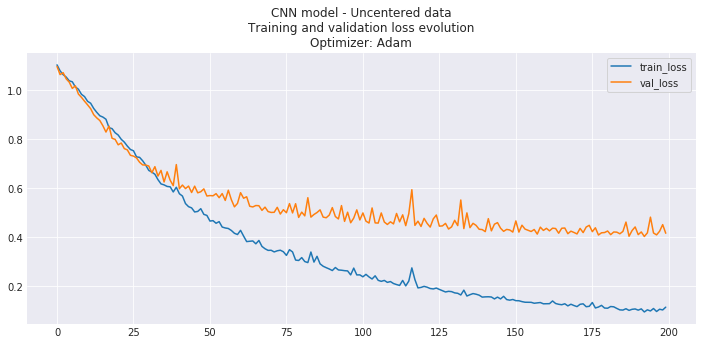

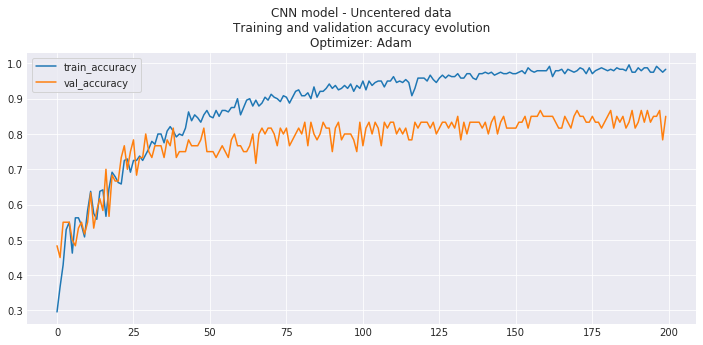

In [80]:
plt.figure(figsize=(12, 5))
plt.title("CNN model - Uncentered data\n"
          "Training and validation loss evolution\n"
         "Optimizer: Adam")
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend(frameon=True);

plt.figure(figsize=(12, 5))
plt.title("CNN model - Uncentered data\n"
        "Training and validation accuracy evolution\n"
         "Optimizer: Adam")
plt.plot(history.history["acc"], label="train_accuracy")
plt.plot(history.history["val_acc"], label="val_accuracy")
plt.legend(frameon=True);

**Comment:**

* We get a much better validation accuracy with the ``CNN`` model on the same data and on the same number of epochs.

* The testing results should reflect that.

In [83]:
# Reshape X_test
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
score = cnn_model.evaluate(X_test, Y_test)
print(f"Testing loss: {round(score[0], 3)}")
print(f"Testing accuracy: {round(score[1], 3)}")

300/300 [==============================] - 0s 1ms/step
Testing loss: 0.503
Testing accuracy: 0.81


**Comment:**

* As expected, the convolutional neural network outperforms the linear classifier. We indeed get an increase of 0.24 on the testing accuracy.

## 6 - A Regression Problem

In [9]:
X_train, Y_train = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


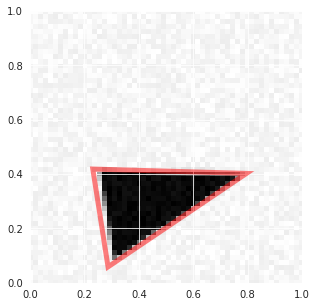

Edges coordinates:  [0.2307953  0.41849789 0.28685254 0.05862279 0.79626222 0.40249419]


In [10]:
visualize_prediction(X_train[0], Y_train[0])
print("Edges coordinates: ", Y_train[0])

In [11]:
# Reshape training samples
X_train = X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

**Comment:**

The triangle edges are described as follow:
1. Edge 1 x-coordinate
2. Edge 1 y-coordinate
3. Edge 2 x-coordinate
4. Edge 2 y-coordinate
5. Edge 3 x-coordinate
6. Edge 3 y-coordinate

Note that the edge ordering does not have any meaning and any permutation would yield the same resulting triangle.
This needs to be accounted for in the evaluation scheme.

In [15]:
def normalize_edges(Y):
    """
    Normalize triangle edges such that the edges 
    are ordered by their X-axis coordinates
    
    Parameters
    ------------
    Y : numpy.ndarray
        Array of edges
        
    Returns
    ------------
    Y_normalized : numpy.ndarray
        Array of normalized edges
    """
    Y_normalized = np.zeros_like(Y)
    for i in range(len(Y_normalized)):
        Yix = Y[i, ::2]
        Yiy = Y[i, 1::2]
        idx = np.argsort(Yix)
        Y_normalized[i, ::2] = Yix[idx]
        Y_normalized[i, 1::2] = Yiy[idx]
        
    return Y_normalized

In [16]:
Y_train_normalized = normalize_edges(Y_train)

In [17]:
# Build a regression CNN
N_EDGES = 6
# Build CNN model
regression_model = Sequential()
regression_model.add(Conv2D(filters=16, kernel_size=5, 
                     input_shape=X_train.shape[1:],
                     padding="same"))
regression_model.add(MaxPooling2D(pool_size=5))
regression_model.add(Conv2D(filters=32, kernel_size=5,
                     padding="same"))
regression_model.add(MaxPooling2D(pool_size=5))
regression_model.add(Flatten())
regression_model.add(Dense(N_EDGES, activation="linear"))

print(regression_model.summary())
# Compile and train the model
regression_model.compile(optimizer=Adam(lr=3e-4),
              loss="mse",
              metrics=["accuracy"])
history = regression_model.fit(x=X_train, y=Y_train_normalized, 
                    batch_size=32, 
                    epochs=200, 
                    verbose=0, 
                    shuffle=True, 
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 72, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 14,022
Trainable params: 14,022
Non-trainable params: 0
_________________________________________________________________
None


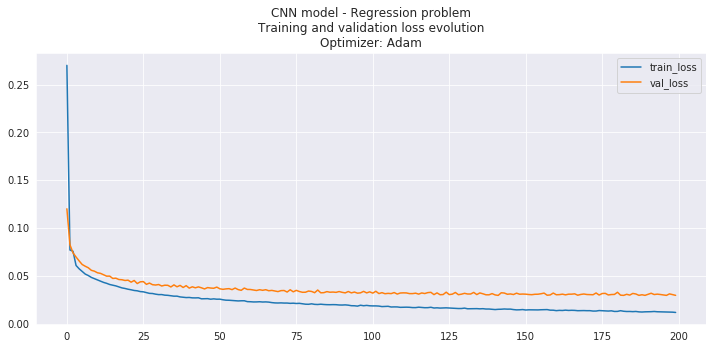

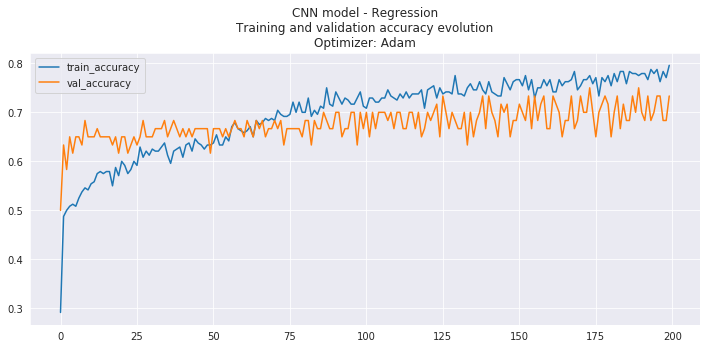

In [18]:
plt.figure(figsize=(12, 5))
plt.title("CNN model - Regression problem\n"
          "Training and validation loss evolution\n"
         "Optimizer: Adam")
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend(frameon=True);

plt.figure(figsize=(12, 5))
plt.title("CNN model - Regression\n"
        "Training and validation accuracy evolution\n"
         "Optimizer: Adam")
plt.plot(history.history["acc"], label="train_accuracy")
plt.plot(history.history["val_acc"], label="val_accuracy")
plt.legend(frameon=True);

**Comment:**

Here we achieve a reasonable performance on both the training and validation sets. Now is time to evaluate the result on the test set.

In [19]:
# Generate test set
X_test, Y_test = generate_test_set_regression()
# Reshape test set
X_test = X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
# Normalized edges
Y_test_normalized = normalize_edges(Y_test)
score = regression_model.evaluate(X_test, Y_test_normalized)
print(f"Testing loss: {round(score[0], 3)}")
print(f"Testing accuracy: {round(score[1], 3)}")

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 914us/step
Testing loss: 0.028
Testing accuracy: 0.637


**Comment:**

Here we see that the evaluation score is lower than both the training and validation scores.

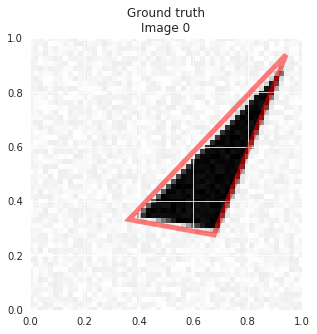

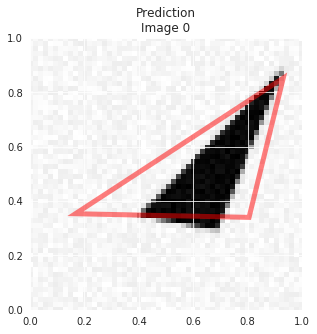

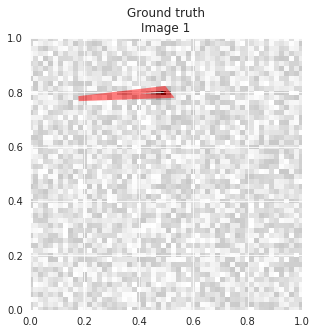

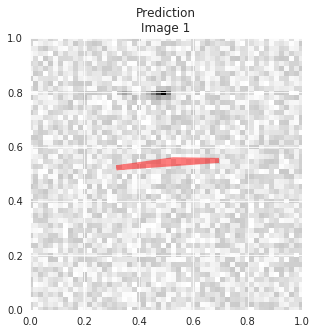

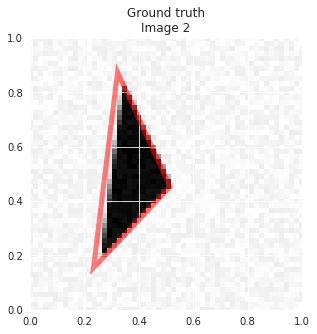

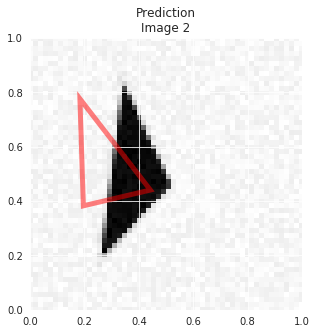

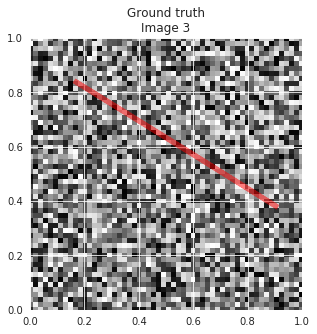

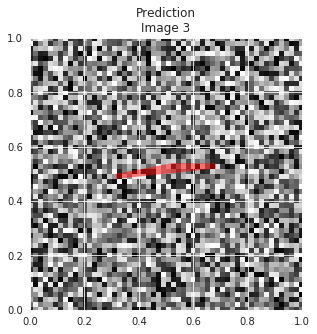

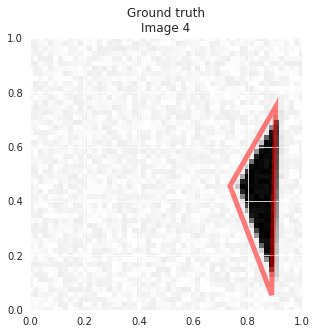

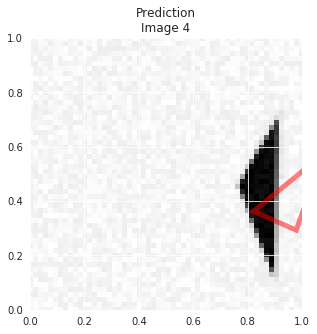

In [21]:
# Display some results (Ground truth versus predicted)
Y_pred = regression_model.predict(X_test)

N_TEST_IMAGES = 5

for i in range(N_TEST_IMAGES):
    visualize_prediction(X_test[i], Y_test[i],
                         title=f"Ground truth\nImage {i}")
    visualize_prediction(X_test[i], Y_pred[i],
                        title=f"Prediction\nImage {i}");

**Comment:**

While the accuracy on the testing set seemed reasonable, here we see that we are still quite far from precisely locating the edges.

Let us see whether it does a better job on the set it was trained on.

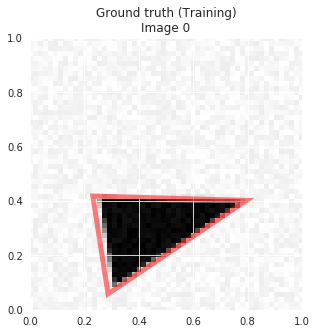

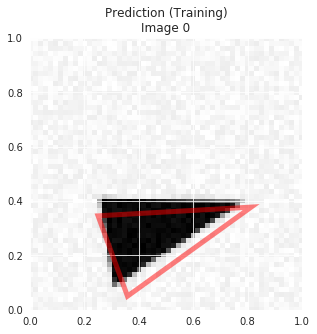

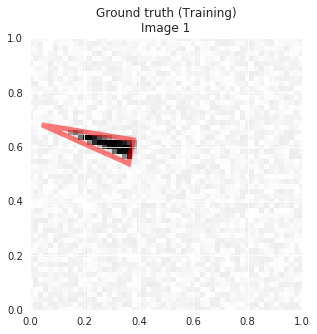

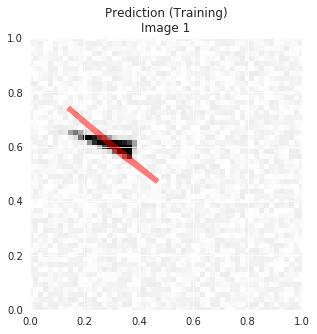

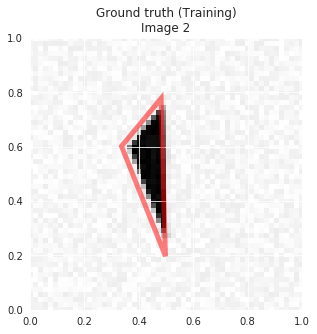

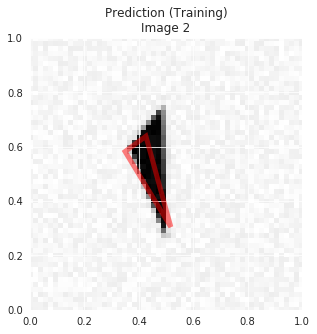

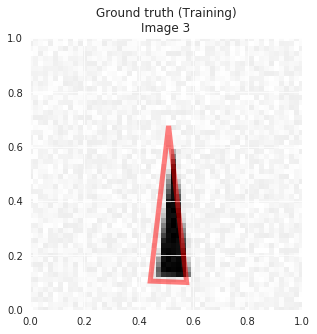

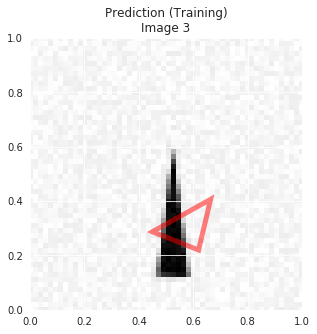

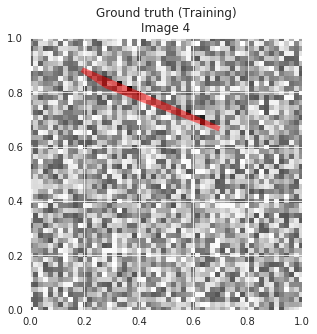

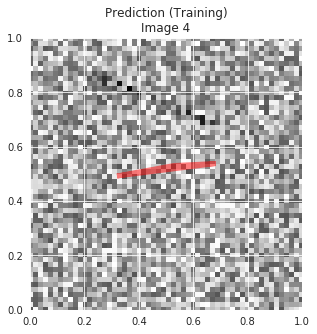

In [23]:
# Display some results (Ground truth versus predicted)
Y_pred = regression_model.predict(X_train)

N_TEST_IMAGES = 5

for i in range(N_TEST_IMAGES):
    visualize_prediction(X_train[i], Y_train[i],
                         title=f"Ground truth (Training)\nImage {i}")
    visualize_prediction(X_train[i], Y_pred[i],
                        title=f"Prediction (Training)\nImage {i}");

**Comment:**

Even on the training set, the network is far from achieving very accurate predictions.

## 7 - Image Denoising

In this part we want to implement a denoising autoencoder in order to denoise noisy inputs.

First we modify the data generators.

In [43]:
def generate_a_rectangle_denoising(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return (generate_a_drawing(figsize, U, V, noise), # noisy version
            generate_a_drawing(figsize, U, V, 0)) # noise-free version


def generate_a_disk_denoising(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return (generate_a_drawing(figsize, U, V, noise), # noisy version
            generate_a_drawing(figsize, U, V, 0)) # noise-free version

def generate_a_triangle_denoising(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return (generate_a_drawing(figsize, U, V, noise), # noisy version
            generate_a_drawing(figsize, U, V, 0)) # noise-free version

In [44]:
def generate_dataset_denoising(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples, im_size])
    Y = np.zeros([nb_samples, im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle_denoising(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk_denoising(noise, free_location)
        else:
            X[i], Y[i] = generate_a_triangle_denoising(noise, free_location)
    
    #X = (X + noise) / (255 + 2 * noise)
    # Reshape input and ouput
    X = X.reshape(X.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
    Y = Y.reshape(Y.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
    
    return [X, Y]

In [45]:
X_train, Y_train = generate_dataset_denoising(300, noise=20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


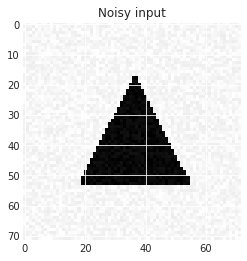

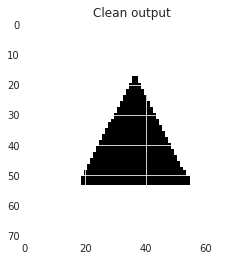

In [57]:
plt.figure()
plt.title("Noisy input")
plt.imshow(X_train[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.figure()
plt.title("Clean output")
plt.imshow(Y_train[0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray');

In [46]:
from keras.layers import Deconv2D
from keras.layers import UpSampling2D

In [67]:
# TODO: Build an autoencoder

dae_model = Sequential()
dae_model.add(Conv2D(filters=16, kernel_size=3, 
                     input_shape=X_train.shape[1:],
                     padding="same"))
dae_model.add(MaxPooling2D(pool_size=3))
dae_model.add(Conv2D(filters=32, kernel_size=3,
                     padding="same"))
dae_model.add(MaxPooling2D(pool_size=3))
dae_model.add(Conv2D(filters=32, kernel_size=3,
                           padding="same"))
dae_model.add(UpSampling2D(size=3))
dae_model.add(Deconv2D(filters=16, kernel_size=3,
                      padding="same"))
dae_model.add(UpSampling2D(size=3))
dae_model.add(Deconv2D(filters=1, kernel_size=3,
                      padding="same", activation="sigmoid"))

print(dae_model.summary())
# Compile and train the model
dae_model.compile(optimizer="adadelta",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history = dae_model.fit(x=X_train, y=Y_train, 
                    batch_size=32, 
                    epochs=200, 
                    verbose=0, 
                    shuffle=True, 
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 72, 72, 16)        160       
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 8, 8, 32)          9248      
_________________________________________________________________
up_sampling2d_29 (UpSampling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_transpose_29 (Conv2DT (None, 24, 24, 16)        4624      
__________

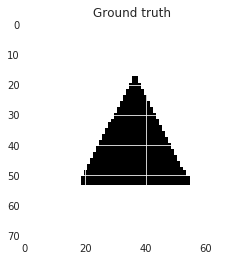

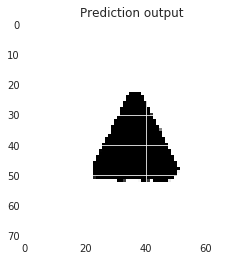

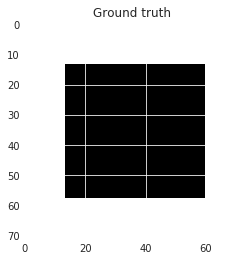

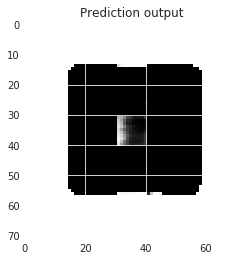

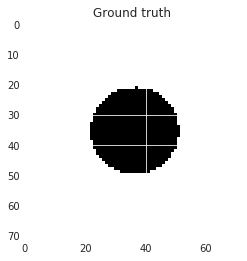

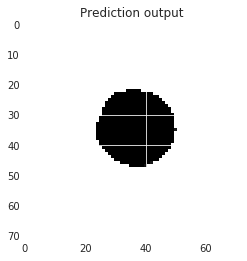

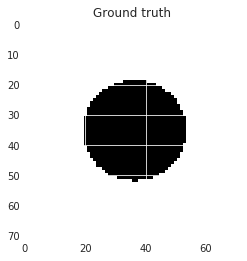

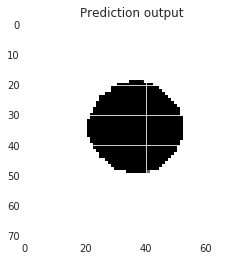

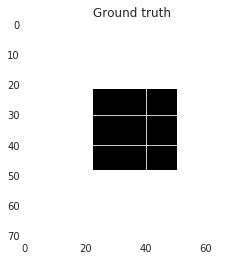

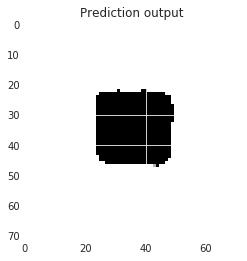

In [68]:
Y_pred = dae_model.predict(X_train)

for i in range(N_TEST_IMAGES):
    plt.figure()
    plt.title("Ground truth")
    plt.imshow(Y_train[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.figure()
    plt.title("Prediction output")
    plt.imshow(Y_pred[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray');

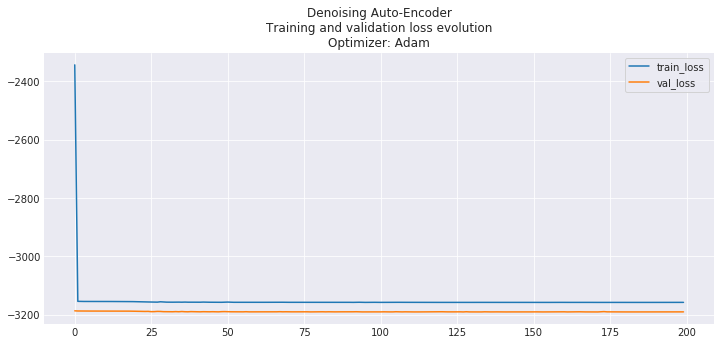

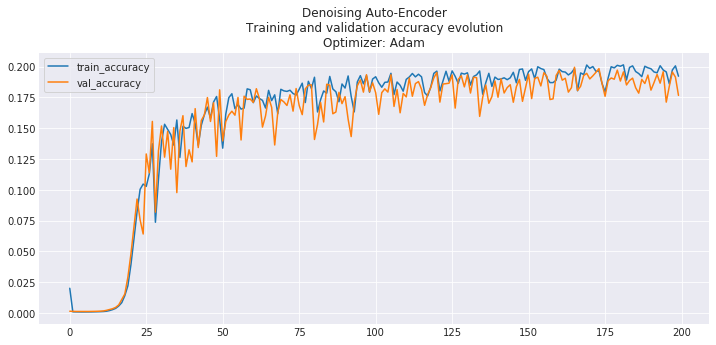

In [69]:
plt.figure(figsize=(12, 5))
plt.title("Denoising Auto-Encoder\n"
          "Training and validation loss evolution\n"
         "Optimizer: Adam")
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend(frameon=True);

plt.figure(figsize=(12, 5))
plt.title("Denoising Auto-Encoder\n"
        "Training and validation accuracy evolution\n"
         "Optimizer: Adam")
plt.plot(history.history["acc"], label="train_accuracy")
plt.plot(history.history["val_acc"], label="val_accuracy")
plt.legend(frameon=True);

In [70]:
X_test, Y_test = generate_dataset_denoising(300, noise=20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


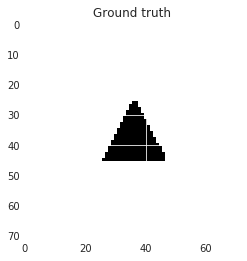

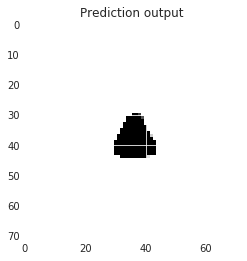

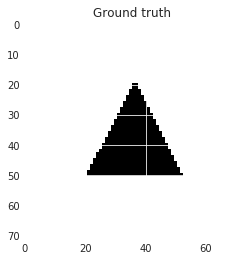

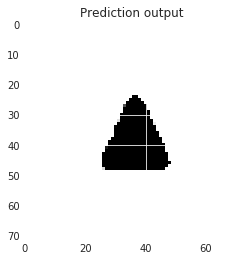

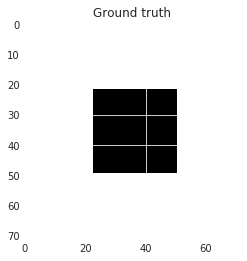

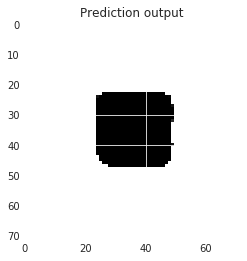

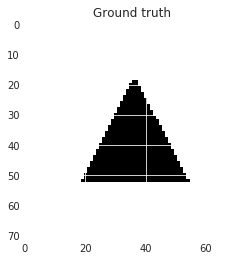

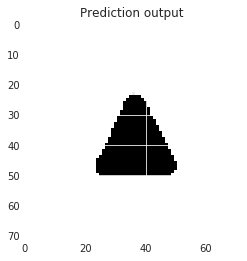

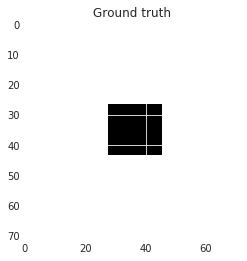

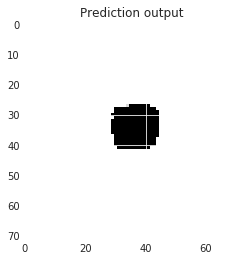

In [71]:
Y_pred = dae_model.predict(X_test)

for i in range(N_TEST_IMAGES):
    plt.figure()
    plt.title("Ground truth")
    plt.imshow(Y_test[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.figure()
    plt.title("Prediction output")
    plt.imshow(Y_pred[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray');

**Comment:**

Overall the resuls are pretty good considering the image resolution (72x72) compared to 28x28 on MNIST. That being said the last testing example shows how the rectangle has been turned into a circle shape.

In [72]:
score = dae_model.evaluate(X_test, Y_test)
print(f"Testing loss: {round(score[0], 3)}")
print(f"Testing accuracy: {round(score[1], 3)}")

300/300 [==============================] - 0s 1ms/step
Testing loss: -3213.437
Testing accuracy: 0.172
